<a href="https://colab.research.google.com/github/AvantiShri/oceanography_colab_notebooks/blob/master/for_rian/FlexibleReminRatios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import cvxpy as cp

In [10]:
!pip install gsw

In [11]:
import gsw

In [12]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ' -O names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv

--2021-01-03 21:32:12--  https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ
Resolving docs.google.com (docs.google.com)... 108.177.126.101, 108.177.126.138, 108.177.126.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2c7ljbh5faedtifgsrrp5i638fitb4e5/1609709475000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download [following]
--2021-01-03 21:32:12--  https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2c7ljbh5faedtifgsrrp5i638fitb4e5/1609709475000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download
Resolving doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-docs.googleusercontent.com)... 108.177.96.132, 2a00:1450:4013:c06::84
Connecting to doc-0s-a4-docs.googleusercontent.com (doc-0s-

In [13]:
def augment_df_with_PO_NO_SiO(df):  
  #remineralization ratios
  r_PO = 155;
  r_SiO = 15
  r_NO = 9.68
  df["PO"] = df["oxygen"] + df["phosphate"]*r_PO
  df["NO"] = df["oxygen"] + df["nitrate"]*r_NO
  df["SiO"] = df["oxygen"] + df["silicate"]*r_SiO

In [14]:
import pandas as pd
import numpy as np

header = ["c"+str(i) for i in range(1,30)]
header[4] = "bottle flag"
header[16] = "bottle salinity flag"
header[20] = "bottle oxygen flag"
header[22] = "silicate flag"
header[24] = "nitrate flag"
header[28] = "phosphate flag"

header[11] = "CTD pressure"
header[12] = "CTD temperature"
header[15] = "practical_salinity" #practical salinity
header[8] = "latitude"
header[9] = "longitude"

header[0] = "stnnbr"
header[5] = "geotrc_ID"
header[10] = "bottom depth"
header[19] = "oxygen"
header[21] = "silicate"
header[23] = "nitrate"
header[27] = "phosphate"

gp15_df = pd.read_csv("names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv",
                      names=header, na_values = -999)

#remove bad data
for flag_type in ["bottle flag", "bottle salinity flag", "bottle oxygen flag",
              "silicate flag", "nitrate flag", "phosphate flag"]:
    gp15_df = gp15_df[gp15_df[flag_type] <= 2]
gp15_df = pd.DataFrame(gp15_df)

#create PO offset
#gp15_df["phosphate"] = gp15_df["phosphate"] - 0.2

#add PO and NO to data frame
augment_df_with_PO_NO_SiO(gp15_df)

absolute_salinity = gsw.SA_from_SP(SP=gp15_df["practical_salinity"],
                                   p=gp15_df["CTD pressure"],
                                   lon=gp15_df["longitude"],
                                   lat=gp15_df["latitude"])
gp15_df["absolute_salinity"] = absolute_salinity

conservative_temp = gsw.CT_from_t(SA=absolute_salinity,
                                  t=gp15_df["CTD temperature"],
                                  p=gp15_df["CTD pressure"])
gp15_df["conservative_temp"] = conservative_temp

potential_temp = gsw.pt_from_CT(SA=absolute_salinity,
                                CT=conservative_temp)
gp15_df["potential_temp"] = potential_temp

sig0 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=0) - 1000
gp15_df["sig0"] = sig0
sig1500 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=1500) - 1000
sig2000 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=2000) - 1000
sig3000 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=3000) - 1000
sig4000 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=4000) - 1000

z = gsw.z_from_p(p=gp15_df["CTD pressure"], lat=gp15_df["latitude"])
depth = -z #https://github.com/TEOS-10/python-gsw/blob/7d6ebe8114c5d8b4a64268d36100a70e226afaf6/gsw/gibbs/conversions.py#L577
gp15_df["depth"] = depth

spic0 = gsw.spiciness0(SA=absolute_salinity, CT=conservative_temp)
gp15_df["spiciness"] = spic0

#calculation of planetary vorticity
rho_ref = 1000.0 #reference density
Omega = 2*np.pi/86400;
f = np.mean(2*Omega*np.sin(gp15_df["latitude"]*(np.pi/180.0)))
PV = -(f/rho_ref)*(np.gradient(sig0, depth))
gp15_df["PV"] = PV #potential vorticity

print("Rows:",len(gp15_df))
gp15_df = gp15_df.dropna()
print("Rows without NA values:",len(gp15_df))

gp15_df["mass"] = 1

Rows: 940
Rows without NA values: 926


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1072: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1073: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1074: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1080: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


In [15]:

def prepare_water_mass_df(water_mass_arr):
    df = pd.DataFrame(data=water_mass_arr,
                      columns=["watermassname",
                               "potential_temp", "practical_salinity",
                               "oxygen", "phosphate", "silicate",
                               "nitrate", "spiciness", "PV"])
    augment_df_with_PO_NO_SiO(df)
    df["mass"] = 1
    return df

                             #Temp  Sal     Oxy     Phos   Sili   Nitr    Spic      Vort
P16_Emilie_AAIW = ["AAIW",    5.68, 34.307, 237.0,  1.77,  16.60, 25.5,   0.068,    88.86E-12]
PSUW =            ["PSUW",    4.03, 33.38,	174.7,	2.35,  59.34, 31.24,  -0.964,  970.78E-12]
GLODAP_ESSW =     ["ESSW",   12.2,  34.86,  84.6,   1.87,  21.58, 25.87,   1.419,    2.66E-12]
GLODAP_mystery =  ["Mystery", 2.09, 34.53,   36.1,  3.03, 168.87, 43.5,  -0.154,    26.95E-12]
GLODAP_EqPIW =    ["EqPIW",   7.65, 34.60,   48.50, 2.71,  44.53, 38.26,  0.568,     0.01E-12]
GLODAP_NPIW =     ["NPIW",    4.72, 34,      81.8,  2.64,  79.87, 36.48, -0.262,   130.26E-12]
PDW1 =            ["PDW1",    1.78, 34.59,   59.60, 2.92, 166.62, 41.38, -0.140,    19.14E-12]
P16_UCDW =        ["UCDW",    2.6,  34.575, 168,    2.4,   85.7,  34.4,  -0.1,      37.49E-12]
PDW23 =           ["PDW23",   1.23, 34.67,  128.50, 2.62, 164.89, 37.24, -0.182,     6.05E-12]
P16_LCDW =        ["LCDW",    1.62, 34.738, 195,    2.17,  96.6,  31,    -0.066,    12.55E-12]
GLODAP_AABW =     ["AABW",    0.18, 34.70,  219,    2.27, 124.45, 32.57, -0.203,     2.90E-12]


intermediateanddeep_withpenalty_flexibleconversion rian_weighting_withconversion
[('nitrate', 50), ('phosphate', 50), ('oxygen', 10)]
Adding penalty for PSUW


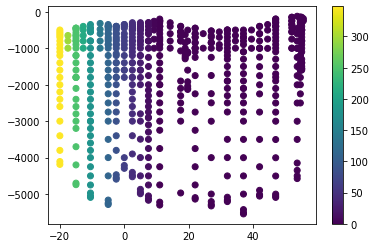

Adding penalty for LCDW


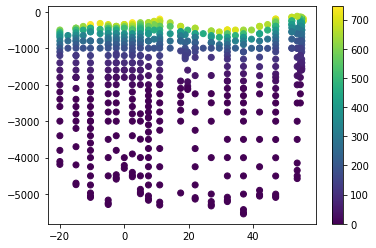

Adding penalty for AABW


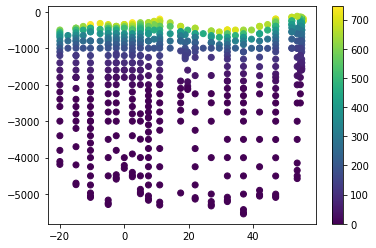

Conversion ratios:
[[ 0.10330579  0.01036168 -1.        ]
 [ 0.10330579  0.00327211 -1.        ]]
params to use: ['potential_temp', 'practical_salinity', 'silicate'] ['nitrate', 'phosphate', 'oxygen']
param weighting: [560 800  30  50  50  10]
ratio [[ 0.10330579  0.01036168 -1.        ]
 [ 0.10330579  0.00327211 -1.        ]]
status: optimal
optimal value 2493893.335853979
status: optimal
optimal value 87233019.58459768
status: optimal
optimal value 2219935.3252125178
objective: 2201712.490109626
intermediateanddeep_withpenalty_staticconversion rian_weighting_withconversion
[('nitrate', 50), ('phosphate', 50), ('oxygen', 10)]
Adding penalty for PSUW


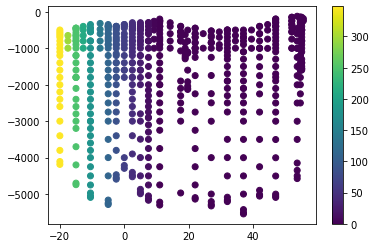

Adding penalty for LCDW


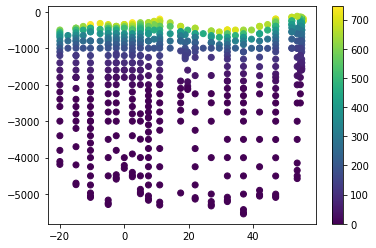

Adding penalty for AABW


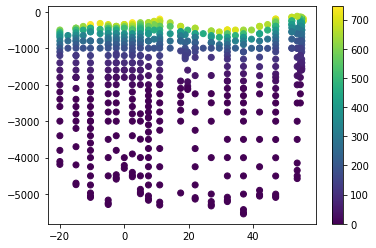

Conversion ratios:
[[ 0.10330579  0.00645161 -1.        ]]
params to use: ['potential_temp', 'practical_salinity', 'silicate'] ['nitrate', 'phosphate', 'oxygen']
param weighting: [560 800  30  50  50  10]
ratio [[ 0.10330579  0.00645161 -1.        ]]
status: optimal
optimal value 2498921.0377445715
status: optimal
optimal value 87233360.93837674
status: optimal
optimal value 2225266.041896245
objective: 2207056.068758995


In [38]:
from collections import OrderedDict


import scipy
import scipy.spatial


def spherical_to_surface_cartesian(lat, lon):
    r = 6.371*(1E3) #earth radius
    theta = ((1-lat)/180.0)*np.pi
    phi = (lon/180.0)*np.pi
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    return (x,y)


def add_surface_cartesian_coordinates_to_df(df):
    latitudes = df["latitude"]
    longitudes = df["longitude"]
    xs,ys = list(zip(*[spherical_to_surface_cartesian(*x)
                       for x in zip(latitudes, longitudes)]))
    df["x"] = xs
    df["y"] = ys
    #plt.scatter(xs, ys)
    #plt.show()


def compute_pairwise_distances_depthmetric(df, depth_metric, depth_scale):
    xs = df["x"]
    ys = df["y"]
    
    depth_metric = np.array(df[depth_metric])
    depth_diffs = np.abs(depth_metric[:,None] -
                         depth_metric[None,:])*depth_scale

    #plt.hist(depth_diffs.ravel(), bins=20)
    #plt.show()

    coors = np.array([xs, ys]).transpose((1,0))
    euclidean_distances = scipy.spatial.distance.squareform(
        scipy.spatial.distance.pdist(coors))
    #plt.hist(euclidean_distances.ravel(), bins=100)
    #plt.show()

    weighted_distances = np.sqrt(np.square(euclidean_distances)
                                 + np.square(depth_diffs))
    #plt.hist(weighted_distances.ravel(), bins=20)
    #plt.show()
    return weighted_distances


def make_pairs_matrix(obs_df, depth_metric, depth_scale, nneighb):
    obs_df = pd.DataFrame(obs_df)
    add_surface_cartesian_coordinates_to_df(obs_df)
    pairwise_distances = compute_pairwise_distances_depthmetric(
        obs_df, depth_metric=depth_metric, depth_scale=depth_scale)
    #plt.hist(pairwise_distances.ravel(), bins=20)
    #plt.show()
    nneighb_thresh = np.sort(pairwise_distances, axis=-1)[:,nneighb]
    masked_pairwise_distances =\
      (pairwise_distances*(pairwise_distances <= nneighb_thresh[:,None])
                         *(pairwise_distances > 0))
    pairs_to_consider_indices = np.nonzero(masked_pairwise_distances)
    print("Constrained pairs:",len(pairs_to_consider_indices[0]))
    pairs_distances = pairwise_distances[
        pairs_to_consider_indices[0],
        pairs_to_consider_indices[1]]
    #plt.hist(pairs_distances.ravel(), bins=20)
    #plt.show()
    pairs_matrix = np.zeros((len(pairs_to_consider_indices[0]),
                              len(obs_df)))
    pairs_matrix[np.arange(len(pairs_distances)),
                  pairs_to_consider_indices[0]] = 1.0/nneighb#(
                      #1/pairs_distances)
    pairs_matrix[np.arange(len(pairs_distances)),
                  pairs_to_consider_indices[1]] = -1.0/nneighb#(
                      #1/pairs_distances)
    return pairs_matrix


def get_exponential_from_bounds_func(lowerbound, upperbound, alpha, beta):
    assert upperbound > lowerbound, (upperbound, lowerbound)
    return lambda x: beta*(np.exp(
        alpha*np.maximum(0, np.maximum(lowerbound-x, x-upperbound)))-1)


def get_combined_penalty_func(lat_penalty_func, sig0_penalty_func):
    return lambda lat, sig0: lat_penalty_func(lat)+sig0_penalty_func(sig0)


def get_wm_penalty_func(latbounds, sig0bounds):
    LAT_ALPHA = 0.05
    LAT_BETA = 100
    SIG0_ALPHA = 0.5
    SIG0_BETA = 1000
    lat_penalty_func = (get_exponential_from_bounds_func(
        lowerbound=latbounds[0], upperbound=latbounds[1],
        alpha=LAT_ALPHA, beta=LAT_BETA)
        if latbounds is not None else lambda x: 0)
    sig0_penalty_func = (get_exponential_from_bounds_func(
        lowerbound=sig0bounds[0], upperbound=sig0bounds[1],
        alpha=SIG0_ALPHA, beta=SIG0_BETA)
        if sig0bounds is not None else lambda x: 0)
    return get_combined_penalty_func(lat_penalty_func=lat_penalty_func,
                                     sig0_penalty_func=sig0_penalty_func)


class OMPAProblem2(object):
         
    def __init__(self, watermass_df,
                       obs_df,
                       paramsandweighting_conserved,
                       paramsandweighting_converted,
                       conversionratios,
                       smoothness_lambda,
                       watermassname_to_usagepenaltyfunc):
        self.watermass_df = watermass_df
        self.watermassnames = list(watermass_df["watermassname"])
        self.obs_df = obs_df
        self.paramsandweighting_conserved = paramsandweighting_conserved
        self.paramsandweighting_converted = paramsandweighting_converted
        self.conversionratios = conversionratios
        self.smoothness_lambda = smoothness_lambda
        self.watermassname_to_usagepenaltyfunc =\
          watermassname_to_usagepenaltyfunc
        self.process_params()

    def prep_watermass_usagepenalty_mat(self):
        watermass_usagepenalty = np.zeros((len(self.obs_df),
                                           len(self.watermassnames)))
        for watermassidx,watermassname in enumerate(self.watermassnames):
            if watermassname in self.watermassname_to_usagepenaltyfunc:
                lat = np.array(obs_df["latitude"])
                sig0 = np.array(obs_df["sig0"])
                penalty = self.watermassname_to_usagepenaltyfunc[watermassname](
                    lat=lat, sig0=sig0)
                watermass_usagepenalty[:,watermassidx] = penalty
                #Plotting
                from matplotlib import pyplot as plt
                print("Adding penalty for",watermassname)
                plt.scatter(lat, -np.array(obs_df["depth"]), c=penalty)
                plt.colorbar()
                plt.show()
        return watermass_usagepenalty

    def process_params(self):
        #check that every param in self.paramsandweighting_converted is
        # specified in convertedparams_ratios
        
        #paramsandweighting_conserved is a list of tuples; split them up
        print(self.paramsandweighting_converted)
        self.conserved_params_to_use, self.conserved_weighting = [
          list(x) for x in zip(*self.paramsandweighting_conserved)]
        if (len(self.paramsandweighting_converted) > 0):
            self.converted_params_to_use, self.converted_weighting = [
              list(x) for x in zip(*self.paramsandweighting_converted)]
        else:
            self.converted_params_to_use, self.converted_weighting = [], []
        
        #make sure every parameter in converted_params_to_use is specified in
        # convertedparams_ratios:
        assert all([(x in self.conversionratios)
                     for x in self.converted_params_to_use])
        #also assert that every entry in convertedratios has the same length
        assert len(set([len(x) for x in self.conversionratios.values()])) == 1
        self.num_conversion_ratios = len(
            list(self.conversionratios.values())[0])

    def solve(self):

        watermass_df = self.watermass_df        
        obs_df = pd.DataFrame(self.obs_df)
        conserved_params_to_use = self.conserved_params_to_use
        converted_params_to_use = self.converted_params_to_use
        weighting = np.array(self.conserved_weighting+self.converted_weighting)
        #conversion_ratios has dimensions:
        # num_conversion_ratios x num_converted_params
        conversion_ratios = np.array([[self.conversionratios[param][i]
                                       for param in converted_params_to_use]
                                    for i in range(self.num_conversion_ratios)])

        watermass_usagepenalty = self.prep_watermass_usagepenalty_mat()
        self.watermass_usagepenalty = watermass_usagepenalty

        print("Conversion ratios:\n"+str(conversion_ratios))
        A = np.array(watermass_df[conserved_params_to_use
                                  +converted_params_to_use])
        #add a row to A for the ratios
        A = np.concatenate([A]+[
                np.array([0 for x in conserved_params_to_use]
                          +list(converted_ratio_row))[None,:]
                for converted_ratio_row in conversion_ratios],
              axis=0)
        b = np.array(obs_df[conserved_params_to_use+converted_params_to_use])
        
        print("params to use:", conserved_params_to_use,
                                converted_params_to_use)        
        print("param weighting:", weighting)
        print("ratio", conversion_ratios)
        A = A*weighting[None,:]
        b = b*weighting[None,:]

        if (self.smoothness_lambda is not None):
            pairs_matrix = make_pairs_matrix(
              obs_df=obs_df,
              depth_metric="depth",
              depth_scale=1.0,
              nneighb=4)
        else:
            pairs_matrix = None

        #first run with only a positive conversion ratio allowed
        _, _, _, individual_residuals_positiveconversionsign, _ =\
          self.core_solve(
            A=A, b=b, conversion_ratios=conversion_ratios, pairs_matrix=None,
            watermass_usagepenalty=watermass_usagepenalty,
            conversion_sign_constraints=1,
            smoothness_lambda=None)
        _, _, _, individual_residuals_negativeconversionsign, _ =\
          self.core_solve(
            A=A, b=b, conversion_ratios=conversion_ratios, pairs_matrix=None,
            watermass_usagepenalty=watermass_usagepenalty,
            conversion_sign_constraints=-1,
            smoothness_lambda=None)
        
        #determine which conversion sign is better
        positive_conversionsign_isbetter = (
            individual_residuals_positiveconversionsign
            < individual_residuals_negativeconversionsign)
        final_conversion_signconstraints = (
            1.0*positive_conversionsign_isbetter
            + -1.0*(positive_conversionsign_isbetter==False))
        
        (x, water_mass_fractions,
         oxygen_deficits,
         residuals_squared, prob) = self.core_solve(
            A=A, b=b, conversion_ratios=conversion_ratios,
            pairs_matrix=pairs_matrix,
            watermass_usagepenalty=watermass_usagepenalty,
            conversion_sign_constraints=final_conversion_signconstraints,
            smoothness_lambda=smoothness_lambda)
        
        self.prob = prob   

        if (water_mass_fractions is not None):
            print("objective:", np.sum(residuals_squared))
            param_reconstruction = (x@A)/weighting[None,:]
            param_residuals = b/weighting[None,:] - param_reconstruction
            self.water_mass_fractions = water_mass_fractions
            self.param_reconstruction = param_reconstruction
            self.param_residuals = param_residuals

        if (oxygen_deficits is not None):
            #sanity check the signs of the oxygen deficits; for each entry they
            # should either be all positive or all negative
            for oxygen_deficit in oxygen_deficits:
                if (len(oxygen_deficit) > 0):
                    assert all(oxygen_deficit > -1e-6)\
                          or all(oxygen_deficit < 1e-6), oxygen_deficit
            total_oxygen_deficit = np.sum(oxygen_deficits, axis=-1)
            #proportions of oxygen use at differnet ratios
            oxygen_usage_proportions = (oxygen_deficits/
                                        total_oxygen_deficit[:,None])
            #Reminder: conversion_ratios has dims of
            # num_conversion_ratios x num_converted_params
            #oxygen_usage_proportions has dims of
            # num_examples X num_conversion_ratios
            effective_conversion_ratios = (
                oxygen_usage_proportions@conversion_ratios)         
            self.total_oxygen_deficit = total_oxygen_deficit
            self.effective_conversion_ratios = effective_conversion_ratios
        else:
            self.total_oxygen_deficit = None
            self.effective_conversion_ratios = None

    def core_solve(self, A, b, conversion_ratios,
                   pairs_matrix, watermass_usagepenalty,
                   conversion_sign_constraints, smoothness_lambda,
                   verbose=True):
  
        #We are going to solve the following problem:
        #P is the penalty matrix. It has dimensions of
        #  (observations X end_members)
        #Minimize (x@A - b)^2 + (x[:,:-len(conversion_ratios)]*P)^2
        #Subject to x[:,:-len(conversion_ratios)] >= 0,
        #           cp.sum(x[:,:-len(conversion_ratios)], axis=1) == 1
        # x has dimensions of observations X (end_members+len(conversion_ratios))
        # the +1 row represents O2 deficit, for remineralization purposes
        # A has dimensions of (end_members+len(conversion_ratios)) X parameteres
        # b has dimensions of observations X parameters 
        
        num_watermasses = len(A)-len(conversion_ratios)
        x = cp.Variable(shape=(len(b), len(A)))
        obj = (cp.sum_squares(x@A - b) +
                cp.sum_squares(cp.atoms.affine.binary_operators.multiply(
                                    x[:,:num_watermasses],
                                    watermass_usagepenalty) ))
        if (smoothness_lambda is not None):
            #leave out O2 deficit column from the smoothness penality as it's
            # on a bit of a different scale.
            obj += smoothness_lambda*cp.sum_squares(
                    pairs_matrix@x[:,:num_watermasses])
        obj = cp.Minimize(obj)
        
        #leave out the last column as it's the conversion ratio
        constraints = [
           x[:,:num_watermasses] >= 0,
           cp.sum(x[:,:num_watermasses],axis=1)==1]
        if (len(conversion_ratios) > 0):
            if (hasattr(conversion_sign_constraints, '__len__')==False):
                constraints.append(
                  cp.atoms.affine.binary_operators.multiply(
                      conversion_sign_constraints,
                      x[:,num_watermasses:]) >= 0)
            else:
                constraints.append(
                  cp.atoms.affine.binary_operators.multiply(
                      np.tile(A=conversion_sign_constraints[:,None],
                              reps=(1,len(conversion_ratios))),
                      x[:,num_watermasses:]) >= 0)
        prob = cp.Problem(obj, constraints)
        prob.solve(verbose=False, max_iter=50000)
        #settign verbose=True will generate more print statements and slow down the analysis
        
        print("status:", prob.status)
        print("optimal value", prob.value)

        if (prob.status=="infeasible"):
            water_mass_fractions = None
            oxygen_deficits = None
            residuals_squared = None
        else:
          water_mass_fractions = x.value[:,:num_watermasses]
          if (conversion_ratios.shape[1] > 0):
             oxygen_deficits = x.value[:,num_watermasses:]
          else:
             oxygen_deficits = None
          residuals_squared = np.sum(np.square((x.value@A) - b), axis=-1)
        
        return (x.value,
                water_mass_fractions,
                oxygen_deficits,
                residuals_squared, prob)


gp15_intermediate = gp15_df[(gp15_df["sig0"] >= 26.6)
                            & (gp15_df["sig0"] <= 27.72)]

gp15_intermediateanddeep = pd.DataFrame(gp15_df[(gp15_df["sig0"] >= 26.6)])

intermediate_paramsandweighting_nospicy = ([("potential_temp",140),
                                            ("practical_salinity",100),
                                            ("silicate",30),
                                            ("NO",10),
                                            #("PO",10),
                                            #("spiciness",10),
                                            #("PV",10),
                                           ], [])

#default redfield: C:N:P:O = 106:16:1:-155
#Teng et al says C:P is in the range 66 to 209
#Assuming relative ratios of other things stay the same, then -O/P goes from
# -155*(66/106) to -155*(209/106)
conversionratios_flexible = {
    "oxygen": [-1,-1],
    "nitrate": [1.0/9.68, 1.0/9.68],
    "phosphate": [1.0/(155.0*(66.0/106.0)), 1.0/(155.0*(209.0/106.0))],
}

conversionratios_static = {
    "oxygen": [-1],
    "nitrate": [1.0/9.68],
    "phosphate": [1.0/155.0],
}

rian_weighting_withconversion = (
 [("potential_temp",560), ("practical_salinity",800),("silicate",30)],
 [("nitrate", 50), ("phosphate", 50), ("oxygen", 10)])

rian_weighting_noconversion = (
 [("potential_temp",560), ("practical_salinity",800),
  ("silicate",30), ("NO",10),("PO",5)], [])

watermassdfname_to_dfs = OrderedDict()  

watermass_usagepenalty = {
    PSUW[0]: get_wm_penalty_func(latbounds=(10,np.inf), sig0bounds=None),
    P16_LCDW[0]: get_wm_penalty_func(latbounds=None,
                                     sig0bounds=(27.72,np.inf)),
    GLODAP_AABW[0]: get_wm_penalty_func(latbounds=None,
                                        sig0bounds=(27.72,np.inf))}

watermassdfname_to_dfs['intermediateanddeep_withpenalty_flexibleconversion'] =\
  (prepare_water_mass_df([P16_Emilie_AAIW,
                          PSUW,
                          GLODAP_ESSW,
                          GLODAP_NPIW,
                          PDW1,
                          P16_UCDW,
                          PDW23,
                          P16_LCDW,
                          GLODAP_AABW
                          ]),
   gp15_intermediateanddeep,
   watermass_usagepenalty,
   conversionratios_flexible)
  
watermassdfname_to_dfs['intermediateanddeep_withpenalty_staticconversion'] =\
  (prepare_water_mass_df([P16_Emilie_AAIW,
                          PSUW,
                          GLODAP_ESSW,
                          GLODAP_NPIW,
                          PDW1,
                          P16_UCDW,
                          PDW23,
                          P16_LCDW,
                          GLODAP_AABW
                          ]),
   gp15_intermediateanddeep,
   watermass_usagepenalty,
   conversionratios_static)


ompa_setting_to_soln = OrderedDict()
for watermassdfname, (watermass_df, obs_df, usagepenalty, conversionratios)\
  in watermassdfname_to_dfs.items():
    for (weightingname, (weighting_conserved, weighting_converted)) in [
             ("rian_weighting_withconversion", rian_weighting_withconversion),
             #("rian_weighting_noconversion", rian_weighting_noconversion),
             ]:
        for smoothness_lambda in [None]:#, 10000]:#, 100000, 1000000]:
            print(watermassdfname, weightingname)
            ompa_problem = OMPAProblem2(
              watermass_df = watermass_df,
              obs_df = obs_df,
              paramsandweighting_conserved=weighting_conserved,
              paramsandweighting_converted=weighting_converted,
              conversionratios=conversionratios,
              smoothness_lambda=smoothness_lambda,
              watermassname_to_usagepenaltyfunc=usagepenalty)
            ompa_problem.solve()
            ompa_setting_to_soln[(watermassdfname,
                                  smoothness_lambda,
                                  weightingname)] = ompa_problem


Plotting water mass fractions
Setting: ('intermediateanddeep_withpenalty_flexibleconversion', None, 'rian_weighting_withconversion')


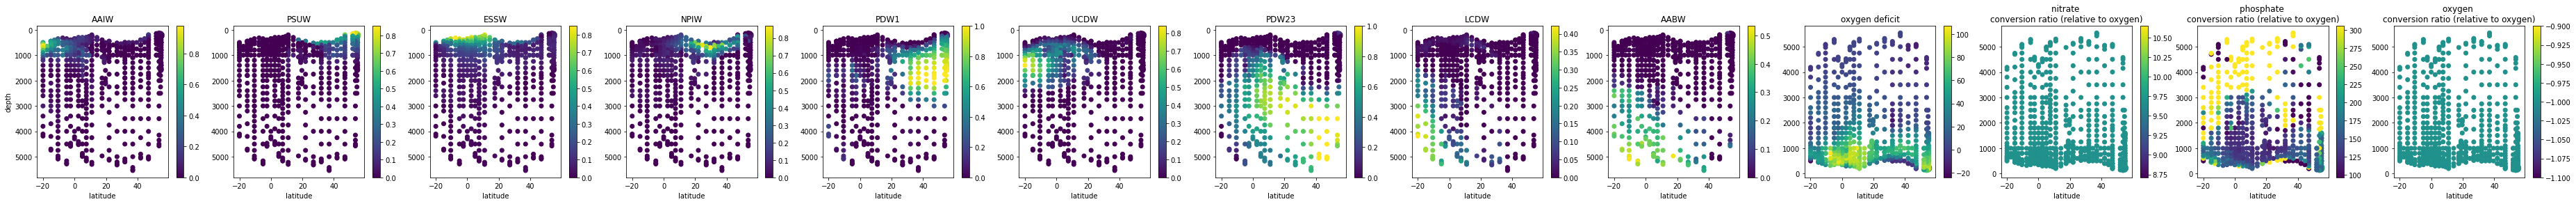

Setting: ('intermediateanddeep_withpenalty_staticconversion', None, 'rian_weighting_withconversion')


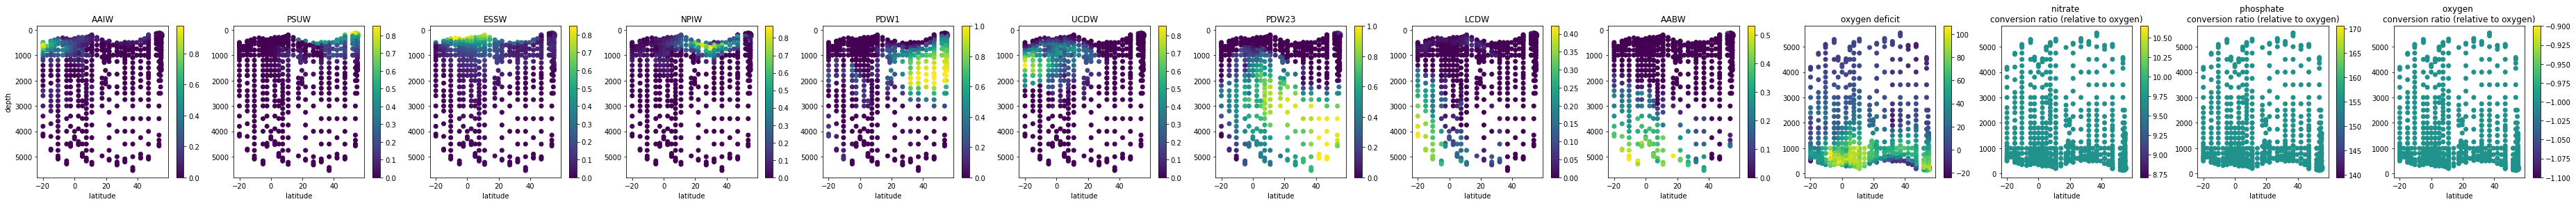

Plotting absolute residuals
Setting: ('intermediateanddeep_withpenalty_flexibleconversion', None, 'rian_weighting_withconversion')


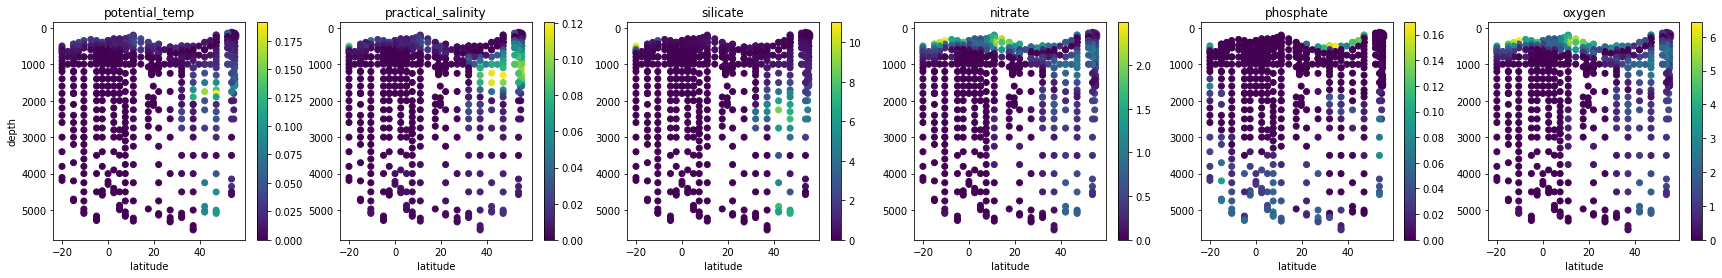

Setting: ('intermediateanddeep_withpenalty_staticconversion', None, 'rian_weighting_withconversion')


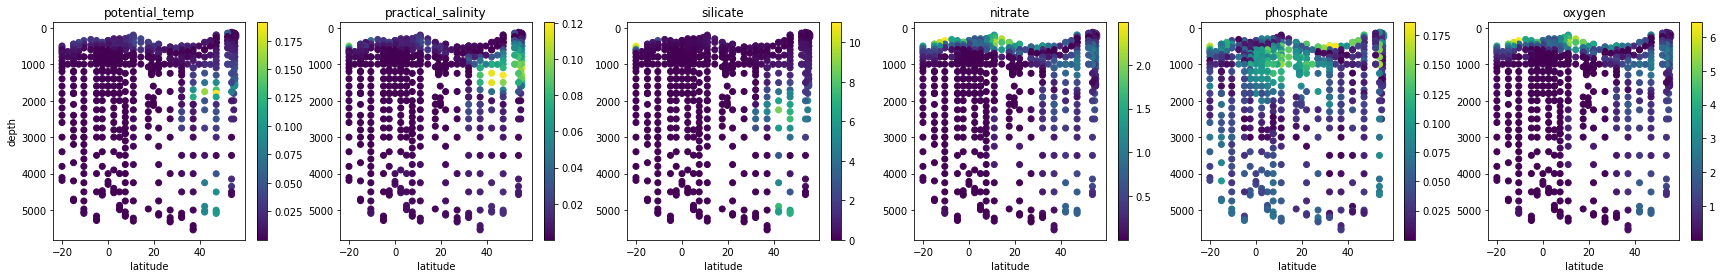

In [39]:
from matplotlib import pyplot as plt


def plot_water_mass_fractions(ompa_problem, yaxis="depth"):
    num_watermasses = ompa_problem.water_mass_fractions.shape[1]
    num_figs = (num_watermasses +
                (1+len(ompa_problem.converted_params_to_use)
                   if ompa_problem.total_oxygen_deficit is not None else 0 ))
    fig, ax = plt.subplots(nrows=1,
        ncols=num_figs, figsize=(5*num_figs,4))
    for i in range(num_watermasses):
        plt.sca(ax[i])
        plt.scatter(ompa_problem.obs_df["latitude"],
                    ompa_problem.obs_df[yaxis],
                    c=ompa_problem.water_mass_fractions[:,i])
        plt.xlabel("latitude")
        if (i==0):
            plt.ylabel("depth")
        plt.ylim(plt.ylim()[1], plt.ylim()[0])
        plt.colorbar()
        plt.title(ompa_problem.watermass_df["watermassname"][i])
    if (ompa_problem.total_oxygen_deficit is not None):
        plt.sca(ax[num_watermasses])
        plt.scatter(ompa_problem.obs_df["latitude"],
                    ompa_problem.obs_df[yaxis],
                    c=ompa_problem.total_oxygen_deficit)
        plt.colorbar()
        plt.xlabel("latitude")
        plt.title("oxygen deficit")
    for i in range(len(ompa_problem.converted_params_to_use)):
        plt.sca(ax[num_watermasses+1+i])
        plt.scatter(ompa_problem.obs_df["latitude"],
                    ompa_problem.obs_df[yaxis],
                    c=1.0/ompa_problem.effective_conversion_ratios[:,i])
        plt.colorbar()
        plt.xlabel("latitude")
        plt.title(ompa_problem.converted_params_to_use[i]
                  +" \nconversion ratio (relative to oxygen)")
    plt.show()


def plot_residuals(ompa_problem):
    num_params = ompa_problem.param_residuals.shape[1]
    fig, ax = plt.subplots(nrows=1, ncols=num_params,
                           figsize=(5*num_params,4))
    params_to_use = (ompa_problem.conserved_params_to_use
                     + ompa_problem.converted_params_to_use)
    for i in range(ompa_problem.param_residuals.shape[1]):
        plt.sca(ax[i])
        plt.scatter(x=ompa_problem.obs_df["latitude"],
                    y=ompa_problem.obs_df["depth"],
                    c=np.abs(ompa_problem.param_residuals[:,i]),
                    cmap="viridis")
        plt.colorbar()
        plt.xlabel("latitude")
        if (i==0):
            plt.ylabel("depth")
        plt.ylim(plt.ylim()[1], plt.ylim()[0])
        plt.title(params_to_use[i])
    plt.show()


print("Plotting water mass fractions")
for setting in ompa_setting_to_soln:
    print("Setting:", setting)
    plot_water_mass_fractions(ompa_setting_to_soln[setting])

print("Plotting absolute residuals")
for setting in ompa_setting_to_soln:
    print("Setting:", setting)
    plot_residuals(ompa_setting_to_soln[setting])  

In [ ]:
import altair as alt
#Build an interactive visualization

CHART_WIDTH=200
CHART_HEIGHT=200
FONTSIZE=10
ROWSIZE=7

def nozero_xaxis(field_name):
  return alt.X(field_name, scale=alt.Scale(zero=False))


def nozero_yaxis(field_name, domain=None):
  if (domain is None):
    return alt.Y(field_name, scale=alt.Scale(zero=False))
  else:
    return alt.Y(field_name, scale=alt.Scale(zero=False, domain=domain))


def latdepth_scatterplot(basechart, selection,
                         property_name, altairdf, zerocenter=False):
    additional_color_kwargs = {}
    if (zerocenter):
        max_abs_property = np.max(np.abs(altairdf[property_name]))
        scale = alt.Scale(scheme='blueorange',
                          domain=[-max_abs_property, max_abs_property])
        additional_color_kwargs['scale'] = scale
    color = alt.condition(selection, property_name, alt.value('lightgray'),
                          title="",
                          **additional_color_kwargs)
    max_depth = np.max(altairdf["depth"])*1.05
    to_return = basechart.encode(
              nozero_xaxis("latitude"),
              nozero_yaxis("depth", domain=(max_depth,0))
           ).encode(color=color).properties(title=property_name)
    return to_return
           

def wrap_scatterplots(scatterplots, resolve_scale='shared'):
    hconcats = [
        alt.hconcat(*scatterplots[i:i+ROWSIZE]).resolve_scale(
            color=resolve_scale)
        for i in range(0,len(scatterplots), ROWSIZE)  
    ]
    return alt.vconcat(*hconcats)


def pp_scatterplot(obs_basechart, selection,
                   watermass_basechart,
                   property1, property2, opacity):
    color = alt.condition(selection, alt.value('lightblue'),
                          alt.value('lightgray'))
    return (obs_basechart.mark_point(opacity=opacity).encode(
                nozero_xaxis(property1),
                nozero_yaxis(property2),
                color=color)
            + watermass_basechart.encode(nozero_xaxis(property1),
                                         nozero_yaxis(property2)))
    

def build_altair_viz(ompa_problem):
    altairdf = pd.DataFrame(ompa_problem.obs_df)
    watermass_names = []
    for water_mass_idx in range(ompa_problem.water_mass_fractions.shape[1]):
      watermass_name =(
        ompa_problem.watermass_df["watermassname"][water_mass_idx]
        if (water_mass_idx < len(ompa_problem.watermass_df["watermassname"]))
        else "oxygen deficit")
      watermass_names.append(watermass_name)
      altairdf[watermass_name] =\
          ompa_problem.water_mass_fractions[:,water_mass_idx]

    params_to_use = ompa_problem.converted_params_to_use+ompa_problem.conserved_params_to_use
    for param_idx in range(ompa_problem.param_residuals.shape[1]):
        param_name = params_to_use[param_idx]
        altairdf[param_name+"_resid"] =\
          ompa_problem.param_residuals[:,param_idx]

    interval_selection = alt.selection_interval()
    tooltip_columns = (params_to_use
                       + ["latitude", "longitude"]
                       + watermass_names
                       + [x+"_resid" for x in params_to_use])
    #make the linked property-property plots
    obs_basechart = alt.Chart(altairdf).mark_point().encode(
      tooltip=tooltip_columns,
      color=alt.condition(interval_selection,
                          alt.value("lightblue"),#"NPIW",
                          alt.value('lightgray'))
      ).add_selection(interval_selection).properties(
          width=CHART_WIDTH,
          height=CHART_HEIGHT)
    
    watermass_basechart =\
      alt.Chart(ompa_problem.watermass_df).mark_point(
          shape="diamond", size=50).encode(
              color="watermassname").properties(
                width=CHART_WIDTH,
                height=CHART_HEIGHT)

    #display a row that is the water mass fractions
    watermass_fraction_scatterplots = [
        latdepth_scatterplot(
            basechart=obs_basechart,
            selection=interval_selection,
            property_name=property_name,
            altairdf=altairdf)
        for property_name in watermass_names[:-1]]

    oxygen_deficit_scatterplot = latdepth_scatterplot(
            basechart=obs_basechart,
            selection=interval_selection,
            property_name="oxygen deficit",
            altairdf=altairdf)

    the_pp_scatterplots = []
    for i in range(len(params_to_use)):
        for j in range(i+1,len(params_to_use)):
            the_pp_scatterplots.append(
                pp_scatterplot(
                    obs_basechart=obs_basechart,
                    selection=interval_selection,
                    watermass_basechart=watermass_basechart,
                    property1=params_to_use[i],
                    property2=params_to_use[j],
                    opacity=0.2)
            )
    
    resid_scatterplots = [
        latdepth_scatterplot(
            basechart=obs_basechart,
            selection=interval_selection,
            property_name=property_name+"_resid",
            altairdf=altairdf,
            zerocenter=True)
        for property_name in params_to_use]

    prop_scatterplots = [
        latdepth_scatterplot(
            basechart=obs_basechart,
            selection=interval_selection,
            property_name=property_name,
            altairdf=altairdf,
            zerocenter=True)
        for property_name in params_to_use]

    return alt.vconcat(
              wrap_scatterplots(watermass_fraction_scatterplots),
              oxygen_deficit_scatterplot,
              wrap_scatterplots(prop_scatterplots, resolve_scale="independent"),
              wrap_scatterplots(resid_scatterplots,
                                resolve_scale='independent'),
              wrap_scatterplots(the_pp_scatterplots))

build_altair_viz(ompa_setting_to_soln[
  ('intermediateanddeep_withpenalty', None, 'rian_weighting_withconversion')])

Plotting what the smoothness penalty would penalize, if it were used

In [ ]:


def latdepth_scatter2(basechart, property_name, depth_metric):
    max_depth = np.max(basechart.data[depth_metric])*1.00
    min_depth = np.min(basechart.data[depth_metric])*1.00
    to_return = basechart.encode(
              nozero_xaxis("latitude"),
              nozero_yaxis(depth_metric, domain=(max_depth,min_depth))
           ).encode(color=property_name).properties(title=property_name)
    return to_return


def plot_penalty(perobs_diffmagsum, ompa_problem, depth_metric):
    watermass_names =\
      list(ompa_problem.watermass_df["watermassname"])+["oxygen deficit"]
    altair_df = pd.DataFrame(
        perobs_diffmagsum,
        columns=[x+"_penalty" for x in watermass_names])
    altair_df["latitude"] = np.array(ompa_problem.obs_df["latitude"])
    altair_df["longitude"] = np.array(ompa_problem.obs_df["longitude"])
    altair_df["depth"] = np.array(ompa_problem.obs_df["depth"])
    altair_df["sig0"] = np.array(ompa_problem.obs_df["sig0"])
    for watermass_idx,watermass_name in enumerate(watermass_names):
      altair_df[watermass_name] =\
        ompa_problem.water_mass_fractions[:,watermass_idx]
    altair_df["obs_idx"] = np.arange(len(ompa_problem.obs_df)) 

    tooltip_columns = (["obs_idx", "latitude", "longitude", "sig0"]
                       + watermass_names
                       + [x+"_penalty" for x in watermass_names])
    basechart = alt.Chart(altair_df).mark_point().encode(
                  tooltip=tooltip_columns).properties(
                    width=CHART_WIDTH,
                    height=CHART_HEIGHT)
    
    watermass_frac_scatterplots = [
       latdepth_scatter2(basechart, property_name,
                         depth_metric=depth_metric)
       for property_name in watermass_names[:-1]]
    penalty_scatterplots = [
      latdepth_scatter2(basechart, property_name+"_penalty",
                        depth_metric=depth_metric)
      for property_name in watermass_names[:]]

    return alt.vconcat(
            wrap_scatterplots(watermass_frac_scatterplots),
            wrap_scatterplots([latdepth_scatter2(basechart, "oxygen deficit",
                               depth_metric=depth_metric)], resolve_scale="independent"),
            wrap_scatterplots(penalty_scatterplots,
                              resolve_scale="independent"))
    
    #print(altair_df)


def compute_perobs_smoothnesspenalty(ompa_problem,
                                     depth_metric="depth",
                                     depth_scale=1):
    intanddeep_pairsmatrix = make_pairs_matrix(
        obs_df=ompa_problem.obs_df,
        depth_metric=depth_metric,
        depth_scale=depth_scale,
        nneighb=4)
    
#    diff_mag_squared = (
#        np.maximum(intanddeep_pairsmatrix@ompa_problem.water_mass_fractions,0))
    diff_mag_squared = (
        np.square(intanddeep_pairsmatrix@ompa_problem.water_mass_fractions))
    obs_to_relatedpairs = np.transpose(
        intanddeep_pairsmatrix*(intanddeep_pairsmatrix > 0), (1,0))
    perobs_diffmagsum = obs_to_relatedpairs@diff_mag_squared 

    #plot_water_mass_fractions(ompa_problem, yaxis="sig0")
    return plot_penalty(
                perobs_diffmagsum=perobs_diffmagsum,
                ompa_problem=ompa_problem,
                depth_metric=depth_metric)

    """num_watermasses = perobs_diffmagsum.shape[1]
    fig, ax = plt.subplots(nrows=1, ncols=num_watermasses,
                           figsize=(5*num_watermasses,4))
    
    for i in range(num_watermasses):
        plt.sca(ax[i])
        plt.scatter(ompa_problem.obs_df["latitude"],
                    ompa_problem.obs_df["sig0"],
                    c=perobs_diffmagsum[:,i])
        plt.xlabel("latitude")
        if (i==0):
            plt.ylabel("depth")
        plt.ylim(plt.ylim()[1], plt.ylim()[0])
        plt.colorbar()
        #plt.clim(0,1)
        plt.title(ompa_problem.watermass_df["watermassname"][i])"""


compute_perobs_smoothnesspenalty(
    ompa_problem=
     ompa_setting_to_soln[('intermediateanddeep_withpenalty', None, 'rian_weighting_withconversion')])

#Only points within 2k of each other should be considered
#np.percentile(pairwise_distances.ravel(), q=[0.1,1,5,10])

Thermocline Analysis

In [ ]:
#Thermocline files include endmembers in the range of potential density 22 to 28 
#the Thomson and Krassovski (2010) definition of PSUW (better performing in previous version of the model) could not have its thermocline potnetial density range expanded
#likely due to lack of observation in the lower potential density range 
#the Tomczak and Godfrey (2003) definition of PSUW was used to obtain the 22-28 range 
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1RhhvaxDue0P6lVpNlXwdzBzQETwnsc1u' -O ENPCW_Den22to28_Oct2020_siderealPV_NO.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Poki02WafLnFpuc196IFOCgdQVQt_yIs' -O PSUW_Den22to28_Oct2020_siderealPV_NO.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=11cJgzVjT98Mkf_vB0gRSzCOTrEbxmz5i' -O ESSW_Den22to28_Oct2020_siderealPV_NO.csv
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1S9QDgIisrGRtST9EXvAMG6lO4Q1XBG3E' -O SPCW_Den22to28_Oct2020_siderealPV_NO.csv

In [ ]:
import pandas as pd

endmemname_to_csv = {
    "PSUW": "PSUW_Den22to28_Oct2020_siderealPV_NO.csv",
    "ENPCW": "ENPCW_Den22to28_Oct2020_siderealPV_NO.csv",
    "ESSW": "ESSW_Den22to28_Oct2020_siderealPV_NO.csv",
    "SPCW": "SPCW_Den22to28_Oct2020_siderealPV_NO.csv"
}
endmemname_to_df ={}

for endmemname in endmemname_to_csv:
  # df=endmemname
  # print(df)
  csv = endmemname_to_csv[endmemname]
  print(csv)
  df = pd.read_csv(csv,names=header, na_values = -999)
  augment_df_with_PO_NO_SiO(df)
  df["watermassname"] = endmemname
  print(df.columns)
  endmemname_to_df[endmemname] = df; 

print(endmemname_to_df["ESSW"])     

In [ ]:

def read_in_thermocline_endmemberdfs(endmemname_to_csv):
    #This function reads in the data frames for the thermocline end members
    #It takes endmemname_to_csv as input, which maps the thermocline
    # end member name (e.g. ENPCW) to the corresponding csv file.
    endmemname_to_df = {}
    #iterate through every endmemname in endmemname_to_csv
    #Order of thermocline endmember file columns: Sig0 pt SP O Si N P PO Pres spic0 vor NO Lat Lon T]);
    #e.g.
    header = ["c"+str(i) for i in range(1,17)] 
    header[0] = "sig0" #potential density 
    header[1] = "potential_temp"
    header[2] = "practical_salinity"
    header[3] = "oxygen"
    header[4] = "silicate"
    header[5] = "nitrate"
    header[6] = "phosphate"
    header[7] = "PO" #remove if calculating this later?
    header[8] = "CTD pressure"
    header[9] = "spiciness" #spiciness
    header[10] = "PV" #potential vorticity
    header[11] = "NO" #remove if calculating this later?
    header[12] = "latitude"
    header[13] = "longitude"
    header[14] = "CTD temperature"
    #make sure header names are compatible
    # with those used in the prepare_water_mass_df function defined earlier
    # for intermediate waters.
    for endmemname in endmemname_to_csv.keys():
      #get the csv file corresponding to the endmemname
      csv = endmemname_to_csv[endmemname]
      #read the csv file into a data frame df
      df = pd.read_csv(csv,names=header, na_values = -999)
      augment_df_with_PO_NO_SiO(df)
      #Also add a column to the df that just has the end member name
      # repeated for each row. This will come in handy later when
      # pairing rows from different data frames
      df["watermassname"] = endmemname
      #store df in endmemname_to_df with the key endmemname
      endmemname_to_df[endmemname] = df; 

    return endmemname_to_df


def get_endmember_df_for_sig0_range(endmemnames_to_use,
                                    endmemname_to_df,
                                    sig0_bin_start,
                                    sig0_bin_end):
  #Idea: for each entry in endmemname_to_df, filter out the row
  # that lies within sig0_bin_start and sig0_bin_end (there should
  # only be one such row). Then assemble all those rows into a data frame
  # of the endmembers to use for the OMPA analysis, for that sig0 range
  
  #We'll create a list of the correct rows from each pandas df
  correct_rows = []
  sig0_bin_start = np.round(sig0_bin_start, decimals=2)
  sig0_bin_end = np.round(sig0_bin_end, decimals=2)
  for endmemname in endmemnames_to_use: #iterate through the endmembers to use
    #apply a filtering to endmemname_to_df to get the right row corresponding
    # to the sig0 range
    df = endmemname_to_df[endmemname]
    correct_rows_for_endmemname =\
    df[(df["sig0"] >= sig0_bin_start) & (df["sig0"] < sig0_bin_end)]
    #correct_rows_for_endmemname is a (view of a) data frame. It should
    # have a length of 1 (there should be only one row for each sig0 bin),
    # so let's verify that with an 'assert' statement.
    assert len(correct_rows_for_endmemname)==1 #will throw error if not true
    #Store the row from this end member dataframe in the list of correct rows
    correct_rows.append(correct_rows_for_endmemname)  
    #print(correct_rows_for_endmemname) 
  #Now we just have to concatenate 'correct_rows' into a single
  # pandas DataFrame; pandas should take care of matching up the
  # columns correctly.
  #this should work, but I haven't used pd.concat often so I'm not 100% sure
  paired_up_endmember_df = pd.concat(correct_rows) 

  return paired_up_endmember_df

#To read in thermocline files via a for loop, first create a dictionary that maps the
# end member name (e.g. PSUW) to the paths for the csv files that
# should be used
endmemname_to_csv = {
    "PSUW": "PSUW_Den22to28_Oct2020_siderealPV_NO.csv",
    "ENPCW": "ENPCW_Den22to28_Oct2020_siderealPV_NO.csv",
    "ESSW": "ESSW_Den22to28_Oct2020_siderealPV_NO.csv",
    "SPCW": "SPCW_Den22to28_Oct2020_siderealPV_NO.csv"
}
#Then, call a function that will run a for loop to read in
# the data frames for the thermocline endmembers.
#The function will return a dictionary that maps the
# thermocline end member to the corresponding dataframe
endmemname_to_df = read_in_thermocline_endmemberdfs(endmemname_to_csv)


In [ ]:
print("First ten rows")
!head "PSUW_Den22to28_Oct2020_siderealPV_NO.csv"
print("last ten rows")
!tail "PSUW_Den22to28_Oct2020_siderealPV_NO.csv"

In [ ]:
#To read in thermocline files via a for loop, first create a dictionary that maps the
# end member name (e.g. PSUW) to the paths for the csv files that
# should be used
endmemname_to_csv = {
    "PSUW": "PSUW_Den22to28_Oct2020_siderealPV_NO.csv",
    "ENPCW": "ENPCW_Den22to28_Oct2020_siderealPV_NO.csv",
    "ESSW": "ESSW_Den22to28_Oct2020_siderealPV_NO.csv",
    "SPCW": "SPCW_Den22to28_Oct2020_siderealPV_NO.csv"
}
#Then, call a function that will run a for loop to read in
# the data frames for the thermocline endmembers.
#The function will return a dictionary that maps the
# thermocline end member to the corresponding dataframe
endmemname_to_df = read_in_thermocline_endmemberdfs(endmemname_to_csv)

#Define thermocline
#By convention, constants are in all caps
TC_UPPER_BOUND = 26.6
TC_LOWER_BOUND = 25.5
TC_STEP = 0.01
therm_endmem_to_use = ["PSUW","ENPCW","ESSW", "SPCW"] #thermocline water masses for analysis
# members to use in the analysis 
gp15_thermocline = gp15_df[(gp15_df["sig0"] >= TC_LOWER_BOUND)
                            & (gp15_df["sig0"] <= TC_UPPER_BOUND)]

rescale = 0.1 #for stabilizing the solver
withspicnoNO_thermocline_paramsandweighting = ([("potential_temp",rescale*200),
                                   ("practical_salinity",rescale*155),
                                   ("silicate",rescale*5),
                                   #("NO",10),
                                   #("PO",10),
                                   ("spiciness",rescale*10),
                                   #("PV",10),
                                   ],
    [#("nitrate", rescale*50, 1.0/9.68),
     #("phosphate", rescale*50, 1.0/155),
     #("oxygen", rescale*10, -1)
     ]
     )

withRemin_thermocline_paramsandweighting = ([("potential_temp",rescale*200),
                                   ("practical_salinity",rescale*155),
                                   ("silicate",rescale*5),
                                   #("NO",10),
                                   #("PO",10),
                                   #("spiciness",10),
                                   #("PV",10),
                                   ],
    [("nitrate", rescale*50, 1.0/9.68),
     ("phosphate", rescale*50, 1.0/155),
     ("oxygen", rescale*10, -1)])

higherSal_thermocline_paramsandweighting = ([("potential_temp",rescale*200),
                                   ("practical_salinity",rescale*600),
                                   ("silicate",rescale*5),
                                   #("NO",10),
                                   #("PO",10),
                                   #("spiciness",10),
                                   #("PV",10),
                                   ],
    [("nitrate", rescale*50, 1.0/9.68),
     ("phosphate", rescale*50, 1.0/155),
     ("oxygen", rescale*10, -1)])

higherSal2_thermocline_paramsandweighting = ([("potential_temp",rescale*200),
                                   ("practical_salinity",rescale*600),
                                   ("silicate",rescale*8),
                                   #("NO",10),
                                   #("PO",10),
                                   #("spiciness",10),
                                   #("PV",10),
                                   ],
    [("nitrate", rescale*50, 1.0/9.68),
     ("phosphate", rescale*150, 1.0/155),
     ("oxygen", rescale*10, -1)])

settings_to_thermoclineomparesults = OrderedDict()

for (t_paramsandweightingname, thermocline_paramsandweighting) in [
          ('withSpic_noNO', withspicnoNO_thermocline_paramsandweighting),
          ('withRemin_noSpic', withRemin_thermocline_paramsandweighting),
          ('withRemin_noSpic_higherSal', higherSal_thermocline_paramsandweighting),
          ('withRemin_noSpic_higherSal_higherSil_higherP', higherSal2_thermocline_paramsandweighting),
          ]:

  #thermocline_ompa_results is a list that will store the results of the OMPA
  # for each sig0 interval
  thermocline_ompa_results = []
  settings_to_thermoclineomparesults[t_paramsandweightingname] =\
    thermocline_ompa_results
  for sig0_bin_start in np.arange(TC_LOWER_BOUND, TC_UPPER_BOUND, TC_STEP):
      sig0_bin_end = sig0_bin_start + TC_STEP
      #Get the endmember dataframe for OMPA analysis corresponding to the
      #sig0 range - the logic for pairing different end members will happen
      # in this function.
      endmember_df_for_sig0_range =\
        get_endmember_df_for_sig0_range(
            endmemnames_to_use=therm_endmem_to_use,
            endmemname_to_df=endmemname_to_df,
            sig0_bin_start=sig0_bin_start,
            sig0_bin_end=sig0_bin_end)
      # It would be good, when testing, to print out paired_up_endmember_df
      # and make sure that things look good visually, to be sure.
      #print(paired_up_endmember_df)
      obs_df_for_sig0_range = gp15_thermocline[
                              (gp15_thermocline["sig0"] >= sig0_bin_start)
                              & (gp15_thermocline["sig0"] <= sig0_bin_end)] #filter gp15_thermocline using sig0_bin_start and sig0_bin_end
      if (len(obs_df_for_sig0_range)==0):
        print("No observations for range", sig0_bin_start, sig0_bin_end)
        continue #skip this iteration of the loop
      
      #Now that you have the data frames for the observations and end members,
      # you can define the ompa problem
      ompa_problem = OMPAProblem2(
                watermass_df = endmember_df_for_sig0_range,
                obs_df = obs_df_for_sig0_range, 
                paramsandweighting_conserved=thermocline_paramsandweighting[0],
                paramsweightingratio_converted=thermocline_paramsandweighting[1],
                smoothness_lambda=None,
                watermassname_to_usagepenaltyfunc={})
                ### Or are 0.01 increments already doing this? ###
      ompa_problem.solve()
      print(ompa_problem.prob.status)
      if (ompa_problem.prob.status is not "infeasible"):
          thermocline_ompa_results.append(ompa_problem)
      else:
          print("Warning! Infeasible for:")
          print("obs df:")
          cols_to_print = ([x[0] for x in thermocline_paramsandweighting[0]]
                          +[x[0] for x in thermocline_paramsandweighting[1]]
                          +["sig0"])
          print(obs_df_for_sig0_range[cols_to_print])
          print("water mass df:")
          print(endmember_df_for_sig0_range[cols_to_print])
      #columns.df to get column names

Visualization of Thermocline 

In [ ]:

def plot_thermocline_water_mass_fractions(ompa_problems_arr, yaxis="depth"):
    #first, check to make sure all entries in ompa_problems_arr have the same
    # number of water masses; the assert statement will throw an error if
    # that is not the case
    num_watermasses = ompa_problems_arr[0].water_mass_fractions.shape[1]
    assert all([x.water_mass_fractions.shape[1]==num_watermasses
                for x in ompa_problems_arr])
    num_to_plot = (num_watermasses-1 if (
        len(ompa_problems_arr[0].converted_params_to_use)==0)
        else num_watermasses)
    fig, ax = plt.subplots(nrows=1, ncols=num_to_plot,
                           figsize=(5*num_to_plot,4))
    
    water_mass_fractions = np.concatenate([
            x.water_mass_fractions for x in ompa_problems_arr], axis=0)
    latitudes = np.concatenate([
            np.array(x.obs_df["latitude"]) for x in ompa_problems_arr])
    yaxis_vals = np.concatenate([
        np.array(x.obs_df[yaxis]) for x in ompa_problems_arr])
        
    print("Number of points:", water_mass_fractions.shape)

    for i in range(num_to_plot):
        plt.sca(ax[i])
        plt.scatter(latitudes,
                    yaxis_vals,
                    c=water_mass_fractions[:,i])
        plt.xlabel("latitude")
        if (i==0):
            plt.ylabel("depth")
        plt.ylim(plt.ylim()[1], plt.ylim()[0])
        plt.colorbar()
        if (i < num_watermasses-1):
          plt.clim(0,1)
          plt.title(list(ompa_problems_arr[0].watermass_df["watermassname"])[i])
        else:
          plt.title("oxygen deficit")
    plt.show()

print("Plotting water mass fractions")
for setting,thermocline_ompa_results in\
  settings_to_thermoclineomparesults.items():
  print(setting)
  plot_thermocline_water_mass_fractions(thermocline_ompa_results)

#print("Plotting absolute residuals")
#for setting in ompa_setting_to_soln:
#    print("Setting:", setting)
#    plot_residuals(ompa_setting_to_soln[setting])  

In [ ]:
def plot_thermocline_residuals(ompa_problems_arr, yaxis="depth"):
    num_params = ompa_problems_arr[0].param_residuals.shape[1]
    fig, ax = plt.subplots(nrows=1, ncols=num_params,
                           figsize=(5*num_params,4))
    
    param_residuals = np.concatenate([
            x.param_residuals for x in ompa_problems_arr], axis=0)
    latitudes = np.concatenate([
            np.array(x.obs_df["latitude"]) for x in ompa_problems_arr])
    yaxis_vals = np.concatenate([
        np.array(x.obs_df[yaxis]) for x in ompa_problems_arr])
        
    print("Number of points:", param_residuals.shape)

    params_to_use = (ompa_problems_arr[0].conserved_params_to_use
                     +ompa_problems_arr[0].converted_params_to_use)
    for i in range(num_params):
        plt.sca(ax[i])
        plt.scatter(latitudes,
                    yaxis_vals,
                    #c=param_residuals[:,i]) #uncomment to have neg and pos residuals 
                    c=np.abs(param_residuals[:,i]))
        plt.xlabel("latitude")
        if (i==0):
            plt.ylabel("depth")
        plt.ylim(plt.ylim()[1], plt.ylim()[0])
        plt.colorbar()
        #plt.clim(0,10)
        #plt.title(list(ompa_problems_arr[0].params_to_use[i]))
        plt.title(params_to_use[i])
    plt.show()

print("Plotting parameter residuals")
for setting,thermocline_ompa_results in\
  settings_to_thermoclineomparesults.items():
  print(setting)
  plot_thermocline_residuals(thermocline_ompa_results[:])



In [ ]:
plt.scatter(gp15_thermocline["potential_temp"],
                    gp15_thermocline["practical_salinity"])
ESSW = endmemname_to_df["ESSW"][
                            (endmemname_to_df["ESSW"]["sig0"] >= TC_LOWER_BOUND)
                            & (endmemname_to_df["ESSW"]["sig0"] <= TC_UPPER_BOUND)] 
PSUW = endmemname_to_df["PSUW"][
                            (endmemname_to_df["PSUW"]["sig0"] >= TC_LOWER_BOUND)
                            & (endmemname_to_df["PSUW"]["sig0"] <= TC_UPPER_BOUND)] 
SPCW = endmemname_to_df["SPCW"][
                            (endmemname_to_df["SPCW"]["sig0"] >= TC_LOWER_BOUND)
                            & (endmemname_to_df["SPCW"]["sig0"] <= TC_UPPER_BOUND)] 
ENPCW = endmemname_to_df["ENPCW"][
                            (endmemname_to_df["ENPCW"]["sig0"] >= TC_LOWER_BOUND)
                            & (endmemname_to_df["ENPCW"]["sig0"] <= TC_UPPER_BOUND)] 
plt.scatter(ESSW["potential_temp"], ESSW["practical_salinity"])
plt.scatter(PSUW["potential_temp"], PSUW["practical_salinity"])
plt.scatter(SPCW["potential_temp"], SPCW["practical_salinity"])
plt.scatter(ENPCW["potential_temp"], ENPCW["practical_salinity"])
plt.xlabel("Potential Temperature")
plt.ylabel("Practical Salinity")
import matplotlib.lines as mlines
green_line = mlines.Line2D([], [],color='green', label='PSUW')
red_line = mlines.Line2D([], [],color='red', label='SPCW')
orange_line = mlines.Line2D([], [],color='orange', label='ESSW')
purple_line = mlines.Line2D([], [],color='purple', label='ENPCW')
plt.legend(handles=[green_line, red_line, orange_line, purple_line])
plt.show()

In [ ]:


def build_thermocline_altair_viz(ompa_problems_arr):

    #verify watermass names are the same for all
    watermass_names = tuple(ompa_problems_arr[0].watermass_df["watermassname"])
    assert all(tuple(x.watermass_df["watermassname"])==watermass_names
               for x in ompa_problems_arr)
    param_names = tuple(ompa_problems_arr[0].conserved_params_to_use
                        + ompa_problems_arr[0].converted_params_to_use)
    assert all(tuple(x.conserved_params_to_use
                     + x.converted_params_to_use)==param_names
               for x in ompa_problems_arr)

    #concatenate all the observations to get a new obs_df
    altairdf = pd.concat([x.obs_df for x in ompa_problems_arr])

    for water_mass_idx in range(ompa_problems_arr[0]
                                .water_mass_fractions.shape[1]):
      watermass_name = (watermass_names[water_mass_idx]
            if water_mass_idx != len(watermass_names) else "oxygen deficit")
      altairdf[watermass_name] = np.concatenate([
        x.water_mass_fractions[:,water_mass_idx]
        for x in ompa_problems_arr])

    for param_idx in range(ompa_problem.param_residuals.shape[1]):
        param_name = param_names[param_idx]
        altairdf[param_name+"_resid"] = np.concatenate([
          x.param_residuals[:,param_idx] for x in ompa_problems_arr])          

    params_to_use = (ompa_problem.conserved_params_to_use
                     +ompa_problem.converted_params_to_use)
    interval_selection = alt.selection_interval()
    tooltip_columns = (list(param_names)
                       + ["latitude", "longitude"]
                       + list(watermass_names)
                       + [x+"_resid" for x in params_to_use])
    
    #make the linked property-property plots
    obs_basechart = alt.Chart(altairdf).mark_point().encode(
      tooltip=tooltip_columns,
      color=alt.condition(interval_selection,
                          alt.value("lightblue"),#"NPIW",
                          alt.value('lightgray'))
      ).add_selection(interval_selection).properties(
          width=CHART_WIDTH,
          height=CHART_HEIGHT)
    
    #prepare a watermass df
    watermass_df = pd.concat([x.watermass_df for x in ompa_problems_arr])

    watermass_basechart =\
      alt.Chart(watermass_df).mark_point(
          shape="diamond", size=50).encode(
              tooltip=list(param_names),
              color="watermassname").properties(
                width=CHART_WIDTH,
                height=CHART_HEIGHT)

    #display a row that is the water mass fractions
    watermass_fraction_scatterplots = [
        latdepth_scatterplot(
            basechart=obs_basechart,
            selection=interval_selection,
            property_name=property_name,
            altairdf=altairdf)
        for property_name in watermass_names]

    oxygen_deficit_scatterplot = latdepth_scatterplot(
            basechart=obs_basechart,
            selection=interval_selection,
            property_name="oxygen deficit",
            altairdf=altairdf)

    the_pp_scatterplots = []
    for i in range(len(params_to_use)):
        for j in range(i+1,len(params_to_use)):
            the_pp_scatterplots.append(
                pp_scatterplot(
                    obs_basechart=obs_basechart,
                    selection=interval_selection,
                    watermass_basechart=watermass_basechart,
                    property1=params_to_use[i],
                    property2=params_to_use[j],
                    opacity=1)
            )
    
    resid_scatterplots = [
        latdepth_scatterplot(
            basechart=obs_basechart,
            selection=interval_selection,
            property_name=property_name+"_resid",
            altairdf=altairdf,
            zerocenter=True)
        for property_name in params_to_use]

    prop_scatterplots = [
        latdepth_scatterplot(
            basechart=obs_basechart,
            selection=interval_selection,
            property_name=property_name,
            altairdf=altairdf,
            zerocenter=True)
        for property_name in params_to_use]

    return alt.vconcat(
              wrap_scatterplots(watermass_fraction_scatterplots),
              oxygen_deficit_scatterplot,
              wrap_scatterplots(prop_scatterplots, resolve_scale="independent"),
              wrap_scatterplots(resid_scatterplots,
                                resolve_scale='independent'),
              wrap_scatterplots(the_pp_scatterplots))
    

build_thermocline_altair_viz(
    settings_to_thermoclineomparesults['withRemin_noSpic_higherSal_higherSil_higherP'])